# Use of RoBERTa Model for Sentiment Analysis!

In [1]:
# Import Libraries
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import DataCollatorWithPadding
import torch
import os

os.environ["WANDB_DISABLED"] = "true"

2024-10-14 18:33:22.571756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 18:33:22.571815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 18:33:22.573013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 18:33:22.579830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 18:33:24.067980: W tensorflow/compiler/tf2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import (
    NaiveBayesClassifier,
)  # NaiveBayes classifer for comparison with RoBERTa transformer model
import numpy as np
import re
import string
import nltk

%matplotlib inline

In [3]:
# Install Hugging Face Transformers and datasets
#!pip install transformers datasets
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
df = pd.read_csv(r"dataset/1429_1.csv")
# df.head()

/tmp/ipykernel_40/4080299592.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"dataset/1429_1.csv")


In [6]:
df.shape

(34660, 21)

In [7]:
# Drop rows where Rating ('Reviews.rating') is missing - about 33 of them in the entire 35K dataset (less than .1%)
df = df.dropna(subset=["reviews.rating"])
df.shape

(34627, 21)

In [8]:
# Add a 'label' column based on 'reviews.rating' which will indicate if it's positive or negative
def label_sentiment(rating):
    if rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive


# Apply the function to create a new column
df["label"] = df["reviews.rating"].apply(label_sentiment)

# Drop rows where 'reviews.text' is missing (if any)
df = df.dropna(subset=["reviews.text"])

# Check the new DataFrame structure
print(df[["reviews.text", "reviews.rating", "label"]].head())
print(df.shape)

                                        reviews.text  reviews.rating  label
0  This product so far has not disappointed. My c...             5.0      2
1  great for beginner or experienced person. Boug...             5.0      2
2  Inexpensive tablet for him to use and learn on...             5.0      2
3  I've had my Fire HD 8 two weeks now and I love...             4.0      2
4  I bought this for my grand daughter when she c...             5.0      2
(34626, 22)


In [23]:
df.to_pickle("df1429_1.pkl")

# df_loaded = pd.read_pickle("df1429_1.pkl")

In [9]:
# Split the dataset into Train and Validation set

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["reviews.text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

Training set size: 27700
Validation set size: 6926


In [10]:
import torch

# Clear the CUDA cache
torch.cuda.empty_cache()

In [11]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
# Create PyTorch datasets from the tokenized ones above, so it can be used in the Model

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Create PyTorch datasetsf
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [13]:
# Due to the input dataset heavily skewed towards positive, need to introduce class weights into the model (to pump up the minority classes)
# No changes to the Dataset

from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import Trainer, TrainingArguments

# Step 1: Compute class weights based on the training labels
class_weights = compute_class_weight("balanced", classes=[0, 1, 2], y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


# Step 2: Modify the model to incorporate class weights in the loss function
class WeightedRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Perform the standard forward pass
        outputs = super().forward(
            input_ids=input_ids, attention_mask=attention_mask, **kwargs
        )

        # Compute the custom loss with class weights
        logits = outputs.logits
        if labels is not None:
            # Move class weights to the same device as the model (either CPU or GPU)
            self.class_weights = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(
                weight=self.class_weights
            )  # Incorporate class weights
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            # Return the loss within the SequenceClassifierOutput structure
            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        else:

            return outputs


# Initialize the custom model with class weights

model = WeightedRobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=3, class_weights=class_weights_tensor
)

# Move the weights to GPU as the model is already there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of WeightedRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WeightedRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [14]:
# Defining Training Argeuments - how the model will be trained

training_args = TrainingArguments(
    output_dir="./results",  # Output directory
    num_train_epochs=3,  # Number of training epochs changed EPOCH TO 3
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Strength of weight decay
    logging_dir="./logs",  # Directory for storing logs
    evaluation_strategy="steps",  # Evaluate every X steps
    logging_steps=500,  # Log every X steps
    save_steps=1000,  # Save model every X steps
    save_total_limit=2,  # Save only the 2 most recent models
    load_best_model_at_end=True,  # Load the best model after training
    eval_steps=500,  # Evaluation frequency
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
""" # CROSS-VALIDATION because the class is skewed to Positive (Ratings 4 & 5) after the Class_weights implementation

from sklearn.model_selection import StratifiedKFold
import numpy as np

# Prepare for Stratified K-Fold Cross-Validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Convert your encodings and labels to NumPy arrays for easier splitting
all_encodings_np = {key: np.array(val) for key, val in train_dataset.encodings.items()}
all_labels_np = np.array(train_dataset.labels)

# List to store results for each fold
fold_results = []

# Start Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(all_labels_np, all_labels_np)):  # stratified split
    print(f"Training fold {fold+1}/{n_splits}")

    # Create the training and validation datasets for this fold
    train_encodings_fold = {key: val[train_idx] for key, val in all_encodings_np.items()}
    val_encodings_fold = {key: val[val_idx] for key, val in all_encodings_np.items()}
    
    train_labels_fold = all_labels_np[train_idx]
    val_labels_fold = all_labels_np[val_idx]

    # Create PyTorch datasets for this fold from the numpy Arrays ///****** Important step as only Pytorch can be processed by RoBERTa  model **///
    train_dataset_fold = SentimentDataset(train_encodings_fold, train_labels_fold)
    val_dataset_fold = SentimentDataset(val_encodings_fold, val_labels_fold)

    # Initialize Trainer for this fold
    trainer = Trainer(
        model=model,                         # Pre-trained RoBERTa model
        args=training_args,                  # Training arguments
        train_dataset=train_dataset_fold,    # Training dataset for the current fold
        eval_dataset=val_dataset_fold,       # Validation dataset for the current fold
        tokenizer=tokenizer,                 # Tokenizer
        data_collator=data_collator          # Data collator for padding
    )

    # Train the model on this fold
    trainer.train()

    # Evaluate the model on the validation set for this fold
    eval_results = trainer.evaluate()
    
    # Save the results for this fold
    fold_results.append(eval_results)
    
    # Print results for this fold
    print(f"Results for fold {fold+1}: {eval_results}")

# After all folds, aggregate and print the results
avg_results = {
    metric: np.mean([fold[metric] for fold in fold_results])
    for metric in fold_results[0].keys()
}

print(f"Average Cross-Validation Results: {avg_results}")
 """

In [15]:
# Initialize the Trainer - with all the defined info from above.
trainer = Trainer(
    model=model,  # pre-trained RoBERTa model
    args=training_args,  # Training arguments as defined above
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Validation dataset
    tokenizer=tokenizer,  # Tokenizer
    data_collator=data_collator,  # Data collator for padding
)

In [16]:
# Train the model now to fine-tune the model for our customer review purposes
trainer.train()

Step,Training Loss,Validation Loss
500,1.130300,1.115325
1000,1.094900,1.067776
1500,1.109200,1.276933
2000,1.049600,1.160660
2500,1.067700,1.235520
3000,1.065500,1.179372
3500,1.049800,1.183160
4000,1.039600,1.187101
4500,1.053400,1.152471
5000,1.058300,1.151021


TrainOutput(global_step=5196, training_loss=1.0712467719262337, metrics={'train_runtime': 637.1639, 'train_samples_per_second': 130.422, 'train_steps_per_second': 8.155, 'total_flos': 5466181253299200.0, 'train_loss': 1.0712467719262337, 'epoch': 3.0})

In [17]:
# Evaluate the model using validation data
results = trainer.evaluate()
print(results)

# Get the predictions and labels from the evaluation set
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

{'eval_loss': 1.0677762031555176, 'eval_runtime': 10.999, 'eval_samples_per_second': 629.692, 'eval_steps_per_second': 9.91, 'epoch': 3.0}


Accuracy: 0.9244874386370199
Precision: 0.9051069870813023
Recall: 0.9244874386370199
F1-Score: 0.9135304217781979
Confusion Matrix:
[[  64   10   83]
 [  52    7  219]
 [ 107   52 6332]]


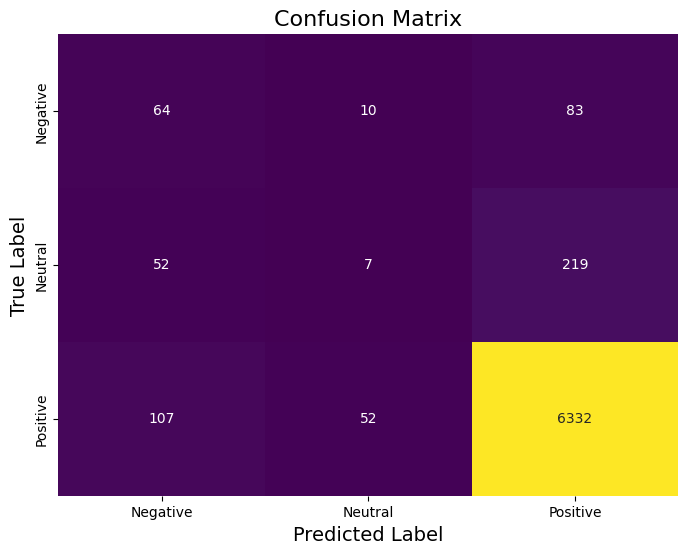

In [18]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    labels, preds, average="weighted"
)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="viridis",
    cbar=False,
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"],
)

# Add labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Display the plot
plt.show()

In [21]:
# Save the model and tokenizer
model.save_pretrained("./sentiment-analysis-roberta-Classweight3")
tokenizer.save_pretrained("./sentiment-analysis-roberta-Classweight3")

('./sentiment-analysis-roberta-Classweight3/tokenizer_config.json',
 './sentiment-analysis-roberta-Classweight3/special_tokens_map.json',
 './sentiment-analysis-roberta-Classweight3/vocab.json',
 './sentiment-analysis-roberta-Classweight3/merges.txt',
 './sentiment-analysis-roberta-Classweight3/added_tokens.json')

In [19]:
# Extract the 'text' from the val_dataset which is a Tensorfile now.
texts = val_texts

# Create a DataFrame with the texts, true labels, and predicted labels
df_results = pd.DataFrame(
    {"Text": texts, "True Label": labels, "Predicted Label": preds}
)

# Save the DataFrame as a CSV file for further analysis
df_results.to_csv("val_pred_classweights3.csv", index=False)

print("Predictions saved to 'val_pred_classweights3.csv'.")

Predictions saved to 'val_pred_classweights3.csv'.


In [25]:
# Example: Inference with new review
new_review = "This product is amazing, I love it!"

# Tokenize the new review
inputs = tokenizer(
    new_review, return_tensors="pt", truncation=True, padding=True, max_length=128
)

# Ensure both model and inputs are on the same device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to GPU (if available)
inputs = {
    key: value.to(device) for key, value in inputs.items()
}  # Move inputs to the same device

# Get model predictions
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)

# Map the predictions to labels
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
print(f"Sentiment: {label_mapping[predictions.item()]}")

Sentiment: Positive


In [30]:
#!pip uninstall pydantic

Found existing installation: pydantic 2.9.2
Uninstalling pydantic-2.9.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/pydantic-2.9.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/pydantic/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [2]:
# NEED to make sure gradio and pydantic versions are compatible with each other
#!pip install gradio
#!pip install --upgrade pydantic

import gradio as gr
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load your pre-trained model and tokenizer
model = RobertaForSequenceClassification.from_pretrained(
    "./sentiment-analysis-roberta-Classweight3"
)
tokenizer = RobertaTokenizer.from_pretrained(
    "./sentiment-analysis-roberta-Classweight3"
)

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Define the function to predict sentiment
def predict_sentiment(review_text):
    # Tokenize the input text
    inputs = tokenizer(
        review_text, return_tensors="pt", truncation=True, padding=True, max_length=128
    )
    inputs = {
        key: value.to(device) for key, value in inputs.items()
    }  # Move inputs to the same device

    # Get the model predictions
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Map the prediction to sentiment labels
    label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_mapping[predictions.item()]


# Create a Gradio interface
interface = gr.Interface(
    fn=predict_sentiment,  # Function to call for predictions
    inputs="text",  # Input is a text box
    outputs="text",  # Output is a text box with the prediction
    title="Sentiment Analysis",  # Title of the web app
    description="Enter a product review to predict the sentiment (Positive, Neutral, Negative).",
)

# Launch the interface
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://28da5aab100162b1d7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
